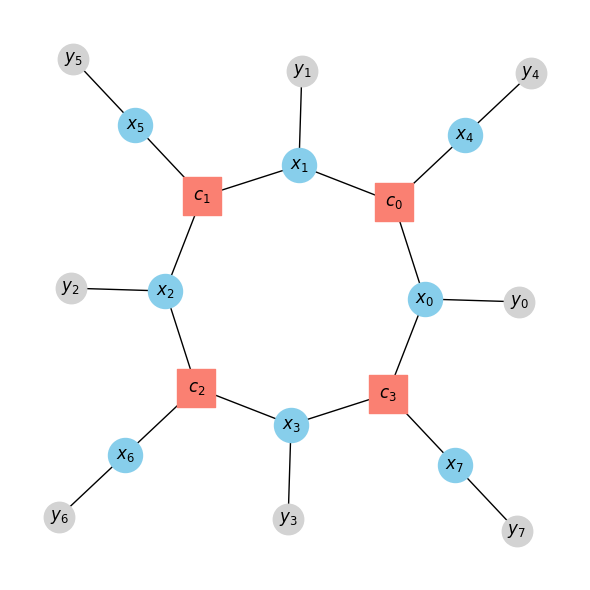

In [1]:
import numpy as np

from qiskit_impl.decoders import decode_bpqm, decode_single_codeword, decode_single_syndrome, create_init_qc
from qiskit_impl.cloner import VarNodeCloner
from qiskit_impl.linearcode import LinearCode

from qiskit import QuantumCircuit

# 1. Define the [8,4] code (Section 6)
G = np.array([
    [1, 0, 0, 0, 1, 0, 0, 1],
    [0, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 0, 1, 1],
])
H = np.array([
    [1, 1, 0, 0, 1, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 1, 0, 0, 1, 0],
    [1, 0, 0, 1, 0, 0, 0, 1],
])

code = LinearCode(G, H)

code.plot_factor_graph(backend="matplotlib")


In [2]:
code.plot_factor_graph(
    backend="pyvis",
    variable_size=100,
    output_size=100,
    output_color="gray",
    font_size=24,
    width="900px",
    height="900px",
    html_file="factor_graph.html",
    latex_subscripts=True,
)


In [3]:
# 3. BPQM decoding
theta = 0.2 * np.pi
cloner = VarNodeCloner(theta)

# 3a. Single‐bit decode (bit index 4)
p_bit = decode_bpqm(
    code,
    theta,
    cloner=cloner,
    height=2,
    mode='bit',
    bit=4,
    only_zero_codeword=True,
    debug=False
)
print("Success probability for bit 4:", p_bit)

# 3b. Full‐codeword decode (bits [0,1,2,3])
p_codeword = decode_bpqm(
    code,
    theta,
    cloner=cloner,
    height=2,
    mode='codeword',
    order=[0, 1, 2, 3],
    only_zero_codeword=True,
    debug=False
)
print("Success probability for the full codeword:", p_codeword)


Success probability for bit 4: 0.8602192421422509
Success probability for the full codeword: 0.6893367460101051


In [4]:
# Decode a specific codeword and obtain the measurement outcome
code = LinearCode(None, H)
message = np.array([0, 0, 1, 1])
codeword = message @ G % 2
corrupted_codeword = codeword.copy()
error_position = 3
corrupted_codeword[error_position] = 1 if corrupted_codeword[error_position] == 0 else 0

qc_init = create_init_qc(
    code=code,
    codeword=corrupted_codeword,
    theta=theta,
    prior=None      # or set a prior like 0.5
)

# 5) Decode with BPQM and print debug counts:
decoded_bits, decoded_qubits, qc_decode = decode_single_codeword(
    qc_init=qc_init,
    code=code,
    cloner=cloner,
    height=2,
    shots=1024,
    debug=True,      # prints reversed & sorted counts + syndrome
    run_simulation=True
)
print("Codeword          : ", codeword)
print("Corrupted codeword: ", corrupted_codeword)
print("Decoded bits      : ", decoded_bits)


Counts:
  00110101 → 329 : syndrome [0 0 0 0]
  00100110 → 140 : syndrome [0 0 0 0]
  10101111 → 68 : syndrome [0 0 0 0]
  00000000 → 52 : syndrome [0 0 0 0]
  11000101 → 51 : syndrome [0 0 0 0]
  00100111 → 26 : syndrome [0 0 0 1]
  10001001 → 22 : syndrome [0 0 0 0]
  11100011 → 18 : syndrome [0 0 0 0]
  00100100 → 17 : syndrome [0 0 1 0]
  01001100 → 16 : syndrome [0 0 0 0]
  01111001 → 14 : syndrome [0 0 0 0]
  00010011 → 14 : syndrome [0 0 0 0]
  00100101 → 13 : syndrome [0 0 1 1]
  00000100 → 10 : syndrome [0 1 0 0]
  10101101 → 10 : syndrome [0 0 1 0]
  00000001 → 9 : syndrome [0 0 0 1]
  10111100 → 9 : syndrome [0 0 0 0]
  00110100 → 7 : syndrome [0 0 0 1]
  00110111 → 7 : syndrome [0 0 1 0]
  10100111 → 6 : syndrome [1 0 0 0]
  10110101 → 6 : syndrome [1 0 0 1]
  00000101 → 5 : syndrome [0 1 0 1]
  00010111 → 5 : syndrome [0 1 0 0]
  01001101 → 5 : syndrome [0 0 0 1]
  00010100 → 5 : syndrome [0 1 1 1]
  01101010 → 5 : syndrome [0 0 0 0]
  00100001 → 5 : syndrome [0 1 1 1]
  0

In [5]:
syndrome = corrupted_codeword @ H.T %2
print("Syndrome: ", syndrome)

Syndrome:  [0 0 1 1]


In [6]:
H = np.array([
    [1, 0, 0, 0, 1],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 1],
    [0, 1, 0, 1, 1],
])
# H = np.array([
#     [1, 1, 0, 0, 1, 0, 0, 0],
#     [0, 1, 1, 0, 0, 1, 0, 0],
#     [0, 0, 1, 1, 0, 0, 1, 0],
#     [1, 0, 0, 1, 0, 0, 0, 1],
# ])
theta = 0.2 * np.pi
cloner = VarNodeCloner(theta)
code = LinearCode(None, H)

corrupted_codeword = np.array([1, 1, 0, 1, 1])
syndrome = corrupted_codeword @ H.T %2
syndrome

array([0, 0, 1, 1])

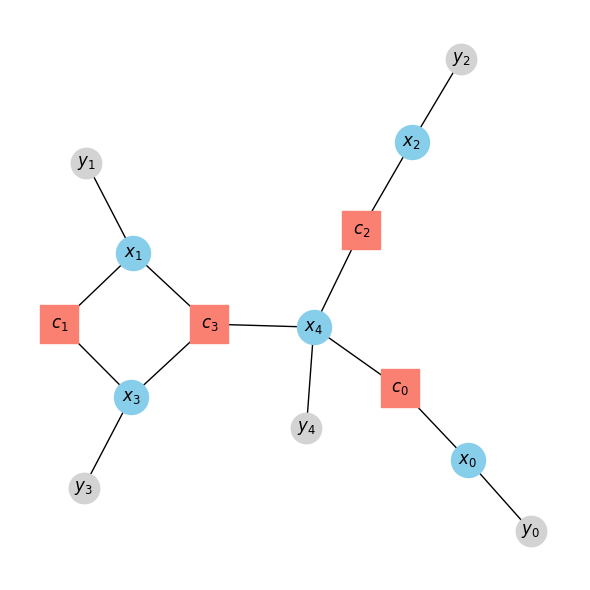

In [7]:
code.plot_factor_graph(backend="matplotlib")


In [8]:
# qc_init = create_init_qc(
#     code=code,
#     codeword=None,
#     theta=theta,
#     prior=0.5      # or set a prior like 0.5
# )

# syndrome_qc = QuantumCircuit(len(syndrome))
# for i, s in enumerate(syndrome):
#     if s == 1:
#         syndrome_qc.x(i)

# decoded_bits, decoded_qubits, qc_decode = decode_single_syndrome_old(
#     qc_init=qc_init,
#     syndrome_qc=syndrome_qc,
#     code=code,
#     cloner=cloner,
#     height=2,
#     shots=512,
#     debug=True,
#     run_simulation=True
# )
# print("syndrome             : ", syndrome)
# print("Corruped codeword    : ", corrupted_codeword)
# print("Decoded bits         : ", decoded_bits)
# if decoded_bits is not None:
#     print("Decoded bits syndrome: ", decoded_bits @ H.T %2)

In [ ]:
syndrome_qc = QuantumCircuit(len(syndrome))
for i, s in enumerate(syndrome):
    if s == 1:
        syndrome_qc.x(i)

decoded_bits, decoded_qubits, qc_decode = decode_single_syndrome(
    syndrome_qc=syndrome_qc,
    code=code,
    prior=0.5,
    theta=theta,
    height=2,
    shots=1024,
    debug=True,
    run_simulation=True
)
print("syndrome             : ", syndrome)
print("Corrupted codeword   : ", corrupted_codeword)
print("Decoded bits         : ", decoded_bits)
if decoded_bits is not None:
    print("Decoded bits syndrome: ", decoded_bits @ H.T %2)

Counts:
  11011 → 223 : syndrome [0 0 1 1]
  10001 → 216 : syndrome [0 0 1 1]
  00100 → 184 : syndrome [0 0 1 0]
  01110 → 156 : syndrome [0 0 1 0]
  01011 → 21 : syndrome [1 0 1 1]
  00000 → 20 : syndrome [0 0 0 0]
  00101 → 17 : syndrome [1 0 0 1]
  00110 → 15 : syndrome [0 1 1 1]
  01100 → 15 : syndrome [0 1 1 1]
  00001 → 15 : syndrome [1 0 1 1]
  01111 → 13 : syndrome [1 0 0 1]
  01010 → 11 : syndrome [0 0 0 0]
  01000 → 11 : syndrome [0 1 0 1]
  00010 → 10 : syndrome [0 1 0 1]
  01101 → 10 : syndrome [1 1 0 0]
  01001 → 10 : syndrome [1 1 1 0]
  00111 → 9 : syndrome [1 1 0 0]
  11010 → 9 : syndrome [1 0 0 0]
  10100 → 7 : syndrome [1 0 1 0]
  00011 → 7 : syndrome [1 1 1 0]
  11110 → 7 : syndrome [1 0 1 0]
  10011 → 6 : syndrome [0 1 1 0]
  10101 → 6 : syndrome [0 0 0 1]
  11111 → 6 : syndrome [0 0 0 1]
  10000 → 5 : syndrome [1 0 0 0]
  11100 → 4 : syndrome [1 1 1 1]
  11000 → 3 : syndrome [1 1 0 1]
  11101 → 3 : syndrome [0 1 0 0]
  10110 → 2 : syndrome [1 1 1 1]
  10010 → 2 : s